In [1]:
# Global imports
import os
import numpy as np
import math
import sys
from time import time
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import matplotlib.pyplot as plt
import warnings

# Imports from support classes

import SupportClass as sc
import DCGAN as dg
import torch.utils.data

In [2]:
# Code cell for preparing data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mnist_train_set, mnist_test_set = sc.download_mnist()
cifar_train_set, cifar_test_set = sc.download_cifar10()

mnist_train_loader, mnist_test_loader = sc.create_data_loaders(mnist_train_set, mnist_test_set)
cifar_train_loader, cifar_test_loader = sc.create_data_loaders(cifar_train_set, cifar_test_set)

# Other global values
opt = dg.Opt()

cuda:0
Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/9912422 [00:00<?, ?it/s]

  0%|          | 0/28881 [00:00<?, ?it/s]

  0%|          | 0/1648877 [00:00<?, ?it/s]

  0%|          | 0/4542 [00:00<?, ?it/s]

In [3]:
# Code cell for preparing the DCGAN model

img_shape = (opt.channels, opt.img_size, opt.img_size)

# Define the loss, generator and discriminator
bce_loss = torch.nn.BCELoss()
dcgan_generator = dg.Generator(img_shape=img_shape, opt=opt)
dcgan_discriminator = dg.Discriminator(img_shape=img_shape)

# Send the models to the device we're working with
dcgan_generator.to(device=device)
dcgan_discriminator.to(device=device)
bce_loss.to(device=device)

# Define the optimizers for the generator and discriminator.
dcgan_generator_optimizer = torch.optim.Adam(dcgan_generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
dcgan_discriminator_optimizer = torch.optim.Adam(dcgan_discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [5]:
# Code cell for training the DCGAN model
saved_imgs = []
for epoch in range(opt.n_epochs):
    start_time = time()
    for i, (imgs, _) in enumerate(mnist_train_loader):
        real = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
        real_imgs = Variable(imgs.type(Tensor))

        # Train the generator
        dcgan_generator_optimizer.zero_grad()

        # Get noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = dcgan_generator(z)

        # Calculate the generator's loss. Its ability to fool the generator
        dcgan_generator_loss = bce_loss(dcgan_discriminator(gen_imgs), real)
        dcgan_generator_loss.backward()
        dcgan_generator_optimizer.step()

        # Train the discriminator
        dcgan_discriminator.zero_grad()

        # Measure the discriminator's loss. Its ability to determine real from fake.
        real_loss = bce_loss(dcgan_discriminator(real_imgs), real)
        fake_loss = bce_loss(dcgan_discriminator(gen_imgs.detach()), fake)

        discriminator_loss = (real_loss + fake_loss) / 2
        discriminator_loss.backward()
        dcgan_discriminator_optimizer.step()
        batches_done = epoch * len(mnist_train_loader) + i
    end_time = time()

    # Get the time to perform this epoch
    epoch_mins, epoch_secs = sc.epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Model name: Baseline Model | Epoch time (Baseline Training): {epoch_mins}m {epoch_secs}s')
    grid = torchvision.utils.make_grid(gen_imgs.data.cpu(), nrow=opt.dim)
    img = (np.transpose(grid.detach().numpy(), (1, 2 ,0)) * 255).astype(np.uint8)
    saved_imgs.append(img)

Epoch: 01 | Model name: Baseline Model | Epoch time (Baseline Training): 0m 23s
Epoch: 02 | Model name: Baseline Model | Epoch time (Baseline Training): 0m 23s
Epoch: 03 | Model name: Baseline Model | Epoch time (Baseline Training): 0m 22s
Epoch: 04 | Model name: Baseline Model | Epoch time (Baseline Training): 0m 22s
Epoch: 05 | Model name: Baseline Model | Epoch time (Baseline Training): 0m 22s
Epoch: 06 | Model name: Baseline Model | Epoch time (Baseline Training): 0m 22s
Epoch: 07 | Model name: Baseline Model | Epoch time (Baseline Training): 0m 23s
Epoch: 08 | Model name: Baseline Model | Epoch time (Baseline Training): 0m 24s
Epoch: 09 | Model name: Baseline Model | Epoch time (Baseline Training): 0m 23s
Epoch: 10 | Model name: Baseline Model | Epoch time (Baseline Training): 0m 23s
Epoch: 11 | Model name: Baseline Model | Epoch time (Baseline Training): 0m 23s
Epoch: 12 | Model name: Baseline Model | Epoch time (Baseline Training): 0m 24s
Epoch: 13 | Model name: Baseline Model |

KeyboardInterrupt: 

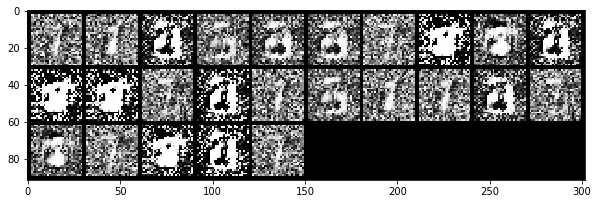

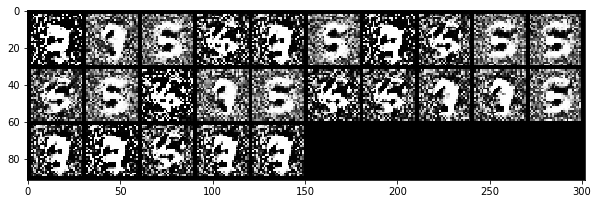

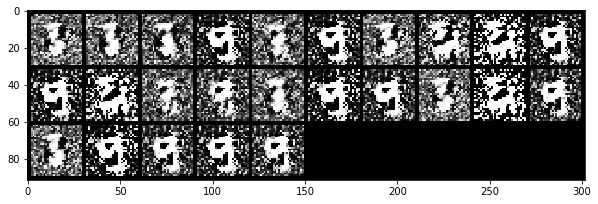

In [6]:
img_indexes = [0, 4, 9, 49, 99, 149, 199]
for i in img_indexes:
    plt.figure(figsize = (opt.dim, opt.dim))
    plt.imshow(saved_imgs[i], interpolation='nearest')